# Ноутбук для поиска вакансий на hh.ru по ключевому слову и получения необходимых для нее skills

Для работы необходимо сначала задать параметры тут и в блоке с ф-цией getPage()

In [1]:
# Путь для сохранения временных json-файлов вакансий
dir_path = 'C:\\Users\\nn250031\\Jypyter_Notebooks\\hh\\'

# Так же для простоты анализа текста описания вакансии создадим словарь ключевых слов
skills_list = ['PYTHON','SQL','JAVA','PANDAS', 'SCALA', 'C++','PYSPARK',
               'POSTGRESQL','ORACLE', 'CLICKHOUSE',
               'LINUX','GIT','GITLAB','BASH','DOCKER', 
               'BIGDATA','SPARK', 'KAFKA','HIVE', 'AIRFLOW', 'FLINK','IMPALA',
               'ETL', 'DWH','СУБД','NOSQL', 'HBASE','CASSANDRA', 'REDSHIFT', 'VERTICA', 'TERADATA', 'GREENPLUM','MONGODB',
               'REDIS', 'HADOOP','STREAMING',  'HDFS', 'SQOOP', 'ELASTICSEARCH', 
               'AWS', 'GCP','CLOUD', 'AZURE', 'BIGQUERY',
               'GRAFANA', 'FLASK', 'JUPITER','BI', 'TABLEAU', 'POWERBI',
                'AVRO', 'PARQUET','ORC', 'XML',  'PRESTO',  'JENKINS', 'RABBITMQ']

In [2]:
# Библиотека для работы с HTTP-запросами. Будем использовать ее для обращения к API HH
import requests
 
# Пакет для удобной работы с данными в формате json
import json
 
# Модуль для работы со значением времени
import time
 
# Модуль для работы с операционной системой. Будем использовать для работы с файлами
import os

# Библиотека для анализа данных
import pandas as pd
 
# Модуль для работы с отображением вывода Jupyter
from IPython import display

# Импорт удобного объекта для подсчета кол-ва вхождений элемента в список
from collections import Counter

# Модули для визуализации в виде облака слов 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

In [3]:
def getPage(page = 0):
    """
    Создаем метод для получения страницы со списком вакансий.
    Аргументы:
        page - Индекс страницы, начинается с 0. Значение по умолчанию 0, т.е. первая страница
    """
    # Справочник для параметров GET-запроса
    params = {
        'text': 'NAME:"data engineer"',  # Текст фильтра. В имени должно быть "data engineer"
        'area': 1,                       # Поиск ощуществляется по вакансиям города Москва
        'vacancy_search_fields': 0,      # поиск только в названии
        'period': 30,                    # за последние 30 дней
        'page': page,                    # Индекс страницы поиска на HH
        'per_page': 100                  # Кол-во вакансий на 1 странице
       }

    req = requests.get('https://api.hh.ru/vacancies', params) # Посылаем запрос к API
    data = req.content.decode() # Декодируем его ответ, чтобы Кириллица отображалась корректно
    req.close()
    return data
 
# Считываем первые 2000 вакансий
for page in range(0, 20):
     
    # Преобразуем текст ответа запроса в справочник Python
    jsObj = json.loads(getPage(page))
     
    # Сохраняем файлы в папку \hh
    # Определяем количество файлов в папке для сохранения документа с ответом запроса
    # Полученное значение используем для формирования имени документа
    nextFileName = dir_path + '{}.json'.format(len(os.listdir(dir_path)))
     
    # Создаем новый документ, записываем в него ответ запроса, после закрываем
    f = open(nextFileName, mode='w', encoding='utf8')
    f.write(json.dumps(jsObj, ensure_ascii=False))
    f.close()
     
    # Проверка на последнюю страницу, если вакансий меньше 3000
    if (jsObj['pages'] - page) <= 1:
        break
     
    # Необязательная задержка, но чтобы не нагружать сервисы hh, оставим. 5 сек мы может подождать
    time.sleep(0.25)
     
print('Старницы поиска собраны')

Старницы поиска собраны


In [4]:
# Получаем перечень ранее созданных файлов со списком вакансий и проходимся по нему в цикле 
for fl in os.listdir(dir_path):
     
    # Открываем файл, читаем его содержимое, закрываем файл
    f = open(dir_path+'{}'.format(fl), encoding='utf8')
    jsonText = f.read()
    f.close()
     
    # Преобразуем полученный текст в объект справочника
    jsonObj = json.loads(jsonText)
     
    # Получаем и проходимся по непосредственно списку вакансий
    for v in jsonObj['items']:
         
        # Обращаемся к API и получаем детальную информацию по конкретной вакансии
        req = requests.get(v['url'])
        data = req.content.decode()
        req.close()
         
        # Создаем файл в формате json с идентификатором вакансии в качестве названия
        # Записываем в него ответ запроса и закрываем файл
        fileName = dir_path+'{}.json'.format(v['id'])
        f = open(fileName, mode='w', encoding='utf8')
        f.write(data)
        f.close()
         
print('Вакансии собраны')

Вакансии собраны


In [5]:
# Создаем списки для столбцов таблицы vacancies
IDs = [] # Список идентификаторов вакансий
names = [] # Список наименований вакансий
descriptions = [] # Список описаний вакансий
 
# Создаем списки для столбцов таблицы skills
skills_vac = [] # Список идентификаторов вакансий
skills_name = [] # Список названий навыков
 
# В выводе будем отображать прогресс
# Для этого узнаем общее количество файлов, которые надо обработать
# Счетчик обработанных файлов установим в ноль
cnt_docs = len(os.listdir(dir_path))
i = 0
 
# Проходимся по всем файлам в папке vacancies
for fl in os.listdir(dir_path):
     
    # Открываем, читаем и закрываем файл
    f = open(dir_path+'{}'.format(fl), encoding='utf8')
    jsonText = f.read()
    f.close()
     
    # Текст файла переводим в справочник
    jsonObj = json.loads(jsonText)
    # Заполняем списки для таблиц. 
    # Обрабатываем исключения так как у нас в папке есть еще файлы со списком вакансий
    try:
        IDs.append(jsonObj["id"])
        names.append(jsonObj['name'])
        descriptions.append(jsonObj['description'])
     
        # Т.к. навыки хранятся в виде массива, то проходимся по нему циклом
        for skl in jsonObj['key_skills']:
            skills_vac.append(jsonObj['id'])
            skills_name.append(skl['name'].upper()) # upper для исключения влияния регистра
     
    # Увеличиваем счетчик обработанных файлов на 1, очищаем вывод ячейки и выводим прогресс
        i += 1
        display.clear_output(wait=True)
        display.display('Готово {} из {}'.format(i, cnt_docs))
    except:
        pass

# Создаем пандосовский датафрейм с описанием вакансий
df = pd.DataFrame({'id': IDs, 'name': names, 'description': descriptions})

# Тоже самое, но для skills
df_skills = pd.DataFrame({'vacancy': skills_vac, 'skill': skills_name})

# Этот объект нам понадобиться для облака слов в дальнейшем
skills_from_vacancy = Counter(skills_name)
 
# Выводим сообщение об окончании программы
display.clear_output(wait=True)
display.display('Вакансии загружены')

'Вакансии загружены'

In [6]:
# Просмотр Топ-20 навыков
df1 = df_skills.groupby('skill').count()
df1.columns = ['cnt']
df1.sort_values(by='cnt', ascending = False).head(20)

,cnt
skill,
PYTHON,63
SQL,59
LINUX,20
JAVA,18
HADOOP,16
SPARK,16
POSTGRESQL,14
ETL,12
GIT,12


При "ручном" просмотре было замечено, что, для многих вакансий не заполнено "key_skills", поэтому попробуем еще распарсить дополнительно описание вакансии по каким-то ключевым словам. 

In [7]:
# Инициализация пустого списка
skills_in_desc =[]

# перебор описания всех вакансий
for index, row in df.iterrows():
    # замена всех символов, которые могут помешать выделить слова на пробелы, чтобы потом по проблеам разделить строку
    words_list = row['description'].upper().replace('<', ' ').replace('>', ' ').replace('/', ' ').replace(':', ' ').replace('(', ' ').replace('>', ' ').split()
    set_words = set (words_list)
    
    for skill in skills_list:
        if skill in set_words:
            skills_in_desc.append(skill)

# Создаем объект Counter для автоподсчета повторений
skills_from_desc = Counter(skills_in_desc)
# Преобразуем в датафремй для удобного просмотра
df2 = pd.DataFrame({'skill': skills_from_desc})
df2.columns = ['cnt']

In [8]:
# получаем Топ-20 навыков, упоминаемых в описании вакансий
df2.sort_values(by='cnt', ascending = False).head(20)

,cnt
PYTHON,58
SQL,57
ETL,52
HADOOP,42
SPARK,33
SCALA,28
JAVA,27
AIRFLOW,21
СУБД,19
BI,19


Теперь все визуализируем более-менее красиво, используя WordCloud

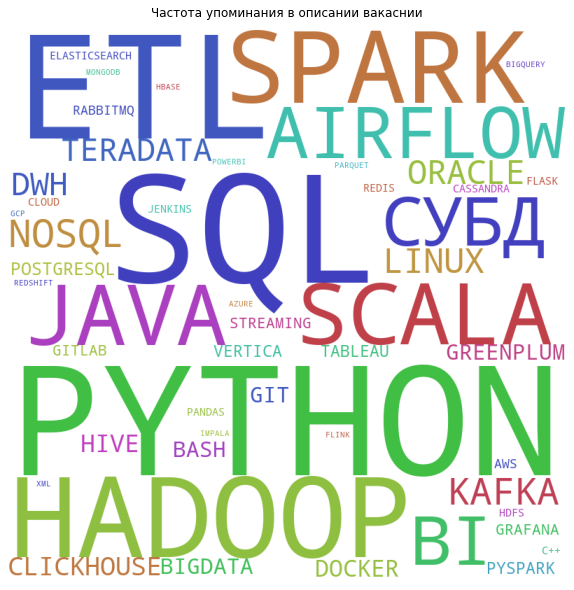

In [9]:
# Создадим ф-цию цвета в зависимости от слова, чтобы на двух диаграммах цвет слов был одинаковый
def my_color_func(word, **kwargs):
    s = 0
    for letter in word:
        s += ord(letter)
    s = s % 360
    return 'hsl(%d, %d%%, %d%%)' % (s, 50, 50)

# Частота упоминания в описании вакаснии
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                prefer_horizontal = 1,
                color_func = my_color_func,
                min_font_size = 10).generate_from_frequencies(skills_from_desc) 

# построить изображение WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Частота упоминания в описании вакаснии')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show() 

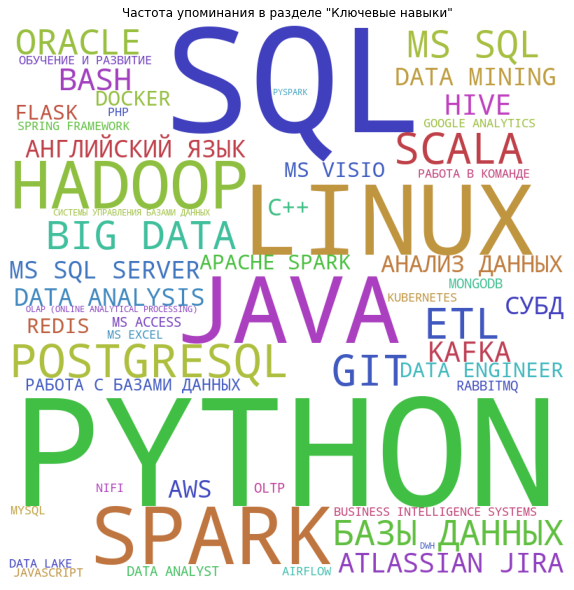

In [10]:
# Частота упоминания в разделе "Клчевые навыки"
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                prefer_horizontal = 1,
                color_func = my_color_func,
                min_font_size = 10).generate_from_frequencies(skills_from_vacancy) 

# построить изображение WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Частота упоминания в разделе "Ключевые навыки"')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show() 